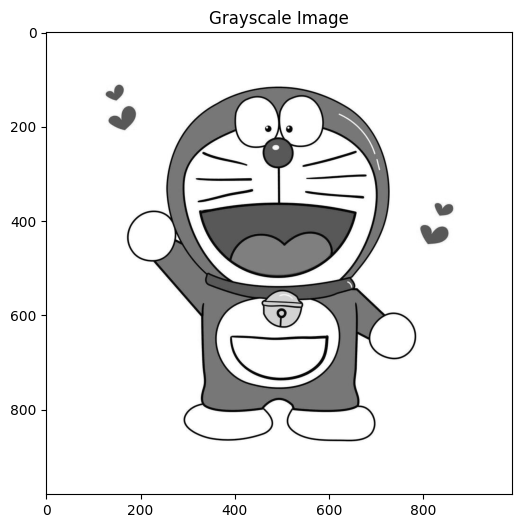

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from skimage import img_as_float
from skimage.transform import resize

# Read image and convert to grayscale
img = Image.open("Image-4.jpg")
gray_img = img.convert('L')  # 'L' mode means grayscale
img_array = np.array(gray_img)

# Plot the grayscale image
plt.figure(figsize=(8, 6))
plt.imshow(img_array, cmap='gray')
plt.title('Grayscale Image')
plt.show()

#### **Resizing the Image**

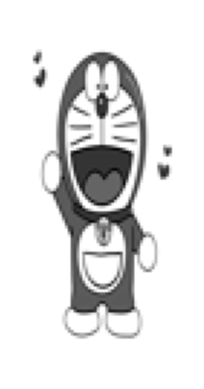

In [128]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Open the image file
image_path = "Image-4.jpg"  # Replace with your image path
image = Image.open(image_path)

# Resize the image to 64x128
resized_image = image.resize((64, 128))

# Save the resized image
resized_image.save("resized_image.png")

# Convert the image to grayscale
gray_image = resized_image.convert("L")

# Convert the grayscale image to an array for matplotlib
gray_image_array = np.array(gray_image)

# Display the image using matplotlib
plt.imshow(gray_image_array, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()


#### **Compute Gradient by Sobel Filter**

In [123]:
def compute_gradients(image):
    """Compute gradient magnitude and direction using Sobel filters."""
    # Sobel filters for x and y gradients
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=np.float32)
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    
    grad_x = cv2.filter2D(image, -1, sobel_x)
    grad_y = cv2.filter2D(image, -1, sobel_y)
    
    # Compute gradient magnitude and direction
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * (180 / np.pi)  # Convert to degrees
    direction[direction < 0] += 180  # Normalize to [0, 180)
    
    return magnitude, direction

#### **Compute Hog**

In [124]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_hog(image, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    """Compute Histogram of Oriented Gradients (HOG) features."""
    # Compute gradients (magnitude and direction)
    magnitude, direction = compute_gradients(image)

    # Define number of cells in x and y directions
    height, width = magnitude.shape
    cells_x = width // cell_size[1]
    cells_y = height // cell_size[0]

    # Create empty HOG feature histogram
    hog_hist = np.zeros((cells_y, cells_x, nbins))

    # Loop over each cell and compute the gradient histogram
    bin_width = 180 // nbins
    for y in range(cells_y):
        for x in range(cells_x):
            # Define the region for the current cell
            cell_mag = magnitude[y * cell_size[0]:(y + 1) * cell_size[0], x * cell_size[1]:(x + 1) * cell_size[1]]
            cell_dir = direction[y * cell_size[0]:(y + 1) * cell_size[0], x * cell_size[1]:(x + 1) * cell_size[1]]

            # Create a histogram for the cell
            for i in range(cell_mag.shape[0]):
                for j in range(cell_mag.shape[1]):
                    # Compute the bin index for the gradient direction
                    angle = cell_dir[i, j]
                    bin_index = int(angle // bin_width) % nbins
                    hog_hist[y, x, bin_index] += cell_mag[i, j]

    # Compute normalized HOG feature vector
    hog_blocks = []
    for y in range(cells_y - block_size[0] + 1):
        for x in range(cells_x - block_size[1] + 1):
            block = hog_hist[y:y + block_size[0], x:x + block_size[1]].flatten()
            # Add small epsilon to prevent division by zero
            norm_block = block / (np.linalg.norm(block) + 1e-8)
            hog_blocks.append(norm_block)
    
    # Flatten the entire feature vector
    hog_vector = np.concatenate(hog_blocks)
    
    return hog_vector, hog_hist

# Compute HOG features for the resized grayscale image
hog_vector, histogram= compute_hog(gray_image_array)

# Display the length of the HOG feature vector (this is a high-dimensional feature representation)
print("HOG Feature Vector Length:", len(hog_vector))

HOG Feature Vector Length: 3780


#### **Visualization**

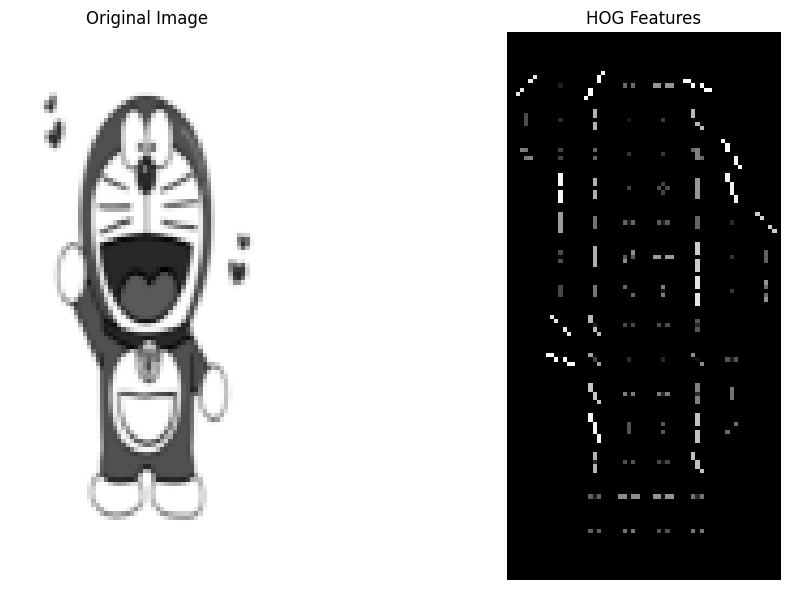

HOG Feature Vector Length: 3780


In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_float

def visualize_hog(histograms, cell_size=(8, 8), target_size=(128, 64)):
    """Visualize the HOG features."""
    h_cells, w_cells, nbins = histograms.shape
    bin_angles = np.linspace(0, 180, nbins + 1)[:-1]  # Bin centers in degrees

    # Create an empty image to draw the visualization (target size)
    vis_h, vis_w = target_size
    hog_image = np.zeros((vis_h, vis_w), dtype=np.float64)

    for i in range(h_cells):
        for j in range(w_cells):
            cell_hist = histograms[i, j]

            # Normalize the cell histogram
            cell_hist = cell_hist / (np.sum(cell_hist) + 1e-5)

            for bin_idx, magnitude in enumerate(cell_hist):
                angle = bin_angles[bin_idx]

                # Calculate line endpoints in the cell
                center_x = int(j * cell_size[1] + cell_size[1] // 2)
                center_y = int(i * cell_size[0] + cell_size[0] // 2)

                dx = int(magnitude * cell_size[1] / 2 * np.cos(np.radians(angle - 90))) # Magnitude-scaled line length
                dy = int(magnitude * cell_size[0] / 2 * np.sin(np.radians(angle - 90)))

                x1, y1 = center_x + dx, center_y + dy
                x2, y2 = center_x - dx, center_y - dy

                #Draw line on a bigger image
                scale_x = vis_w / (w_cells * cell_size[1])
                scale_y = vis_h / (h_cells * cell_size[0])

                x1_scaled, y1_scaled = int(x1 * scale_x), int(y1 * scale_y)
                x2_scaled, y2_scaled = int(x2 * scale_x), int(y2 * scale_y)

                cv2.line(hog_image, (x1_scaled, y1_scaled), (x2_scaled, y2_scaled), (magnitude), thickness=1)

    # Normalize and scale the image for better visualization
    hog_image = hog_image - np.min(hog_image)
    hog_image = hog_image / np.max(hog_image)

    return hog_image

# Main execution
def main():
    # Read the image
    image_path = "Image-4.jpg"  # Replace with your image path
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 64x128
    gray_image = resize(gray_image, (128, 64))
    
    # Ensure the image is float for processing
    gray_image = img_as_float(gray_image)
    
    # Compute HOG features
    hog_vector, hog_hist = compute_hog(gray_image)
    
    # Visualize HOG features
    hog_visualization_image = visualize_hog(hog_hist)
    
    # Display the original and HOG feature image side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(gray_image, cmap='gray')
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(hog_visualization_image, cmap='gray')
    ax2.set_title("HOG Features")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()
    
    # Print the length of the HOG feature vector
    print("HOG Feature Vector Length:", len(hog_vector))

# Run the main function
if __name__ == "__main__":
    main()

## **Built-in**

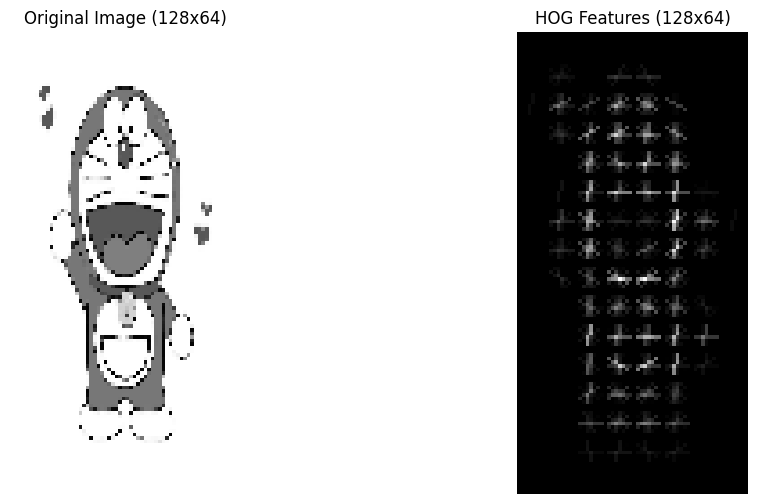

In [132]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

# Provide the correct path to your image
image_path = "Image-4.jpg"  # Replace with your actual image filename
image = cv2.imread(image_path)

# Check if the image is loaded properly
if image is None:
    raise ValueError("Image not found! Please check the file path.")

# Resize the image to 128x64
image_resized = cv2.resize(image, (64, 128))

# Convert to grayscale for HOG computation
gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

# Compute HOG features and get the visualization image
hog_features, hog_image = hog(
    gray,
    orientations=9,             # Number of orientation bins
    pixels_per_cell=(8, 8),     # Size of each cell
    cells_per_block=(2, 2),     # Block size (in cells)
    block_norm='L2-Hys',        # Normalization method
    visualize=True              # Return an image of the HOG
)

# Display the original and HOG feature images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(gray, cmap='gray')
ax1.set_title("Original Image (128x64)")
ax1.axis("off")
ax2.imshow(hog_image, cmap='gray')
ax2.set_title("HOG Features (128x64)")
ax2.axis("off")
plt.show()
